# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Final Project: Milestone 2 - Exploratory Data Analysis (EDA) [3 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Group Members**: Fernando Medeiros, Mohammed Gufran Pathan, and Prerna Aggarwal<br/>

<hr style="height:2pt">

---

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

<div class="theme"> Overview </div> 

As part of your final project,  please perform exploratory data analysis (EDA) on the data you have received. In order to simulate the "real world," the details of this are deliberately left open-ended, so your EDA should be what you consider the best for the domain you are working in and the specifics of the data. Please cite any references that you use when learning more about the topic of your project.

 

Key Questions: 

Given everything you have learned, if you faced this data set in the wild, how would you proceed? 

What are the important measures? 

What are the right questions to ask, and how can the data answer them?

In [98]:
import json
import lzma
import matplotlib as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

In [3]:
f = lzma.open("./data/text/new_mexico.xz","rb")
data = f.readlines()
f.close()
data_json = [json.loads(line) for line in data]
data = json_normalize(data_json)

In [4]:
data.columns

Index(['id', 'url', 'name', 'name_abbreviation', 'decision_date',
       'docket_number', 'first_page', 'last_page', 'citations', 'frontend_url',
       'preview', 'volume.url', 'volume.barcode', 'volume.volume_number',
       'reporter.url', 'reporter.full_name', 'reporter.id', 'court.url',
       'court.name_abbreviation', 'court.slug', 'court.name', 'court.id',
       'jurisdiction.name', 'jurisdiction.name_long',
       'jurisdiction.whitelisted', 'jurisdiction.url', 'jurisdiction.id',
       'jurisdiction.slug', 'casebody.data.judges', 'casebody.data.attorneys',
       'casebody.data.opinions', 'casebody.data.head_matter',
       'casebody.data.corrections', 'casebody.status',
       'casebody.data.parties'],
      dtype='object')

In [5]:
data.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,frontend_url,...,jurisdiction.url,jurisdiction.id,jurisdiction.slug,casebody.data.judges,casebody.data.attorneys,casebody.data.opinions,casebody.data.head_matter,casebody.data.corrections,casebody.status,casebody.data.parties
0,17491,https://api.capapi.org/v1/cases/17491/,"STATE of New Mexico, Plaintiff-Appellee, v. Lo...",State v. Woodruff,1997-11-21,No. 23958,388,399,"[{'type': 'official', 'cite': '124 N.M. 388'},...",https://cite.capapi.org/nm/124/388/,...,https://api.capapi.org/v1/jurisdictions/nm/,52,nm,"[FRANCHINI, C.J., and BACA, SERNA and McKINNON...","[Tangora & Whitley, P.C., Robert E. Tangora, S...","[{'type': 'majority', 'text': 'OPINION MINZNER...",1997-NMSC-061\n951 P.2d 605\nSTATE of New Mexi...,,ok,NaN
1,17129,https://api.capapi.org/v1/cases/17129/,"STATE of New Mexico, ex rel. CHILDREN, YOUTH A...","State ex rel. Children, Youth & Families Depar...",1998-01-29,No. 17771,735,745,"[{'type': 'official', 'cite': '124 N.M. 735'},...",https://cite.capapi.org/nm/124/735/,...,https://api.capapi.org/v1/jurisdictions/nm/,52,nm,"[DONNELLY and BOSSON, JJ., concur.]","[Angela Adams, Chief Children’s Court Attorney...","[{'type': 'majority', 'text': 'OPINION WECHSLE...",1998-NMCA-039\n955 P.2d 204\nSTATE of New Mexi...,,ok,NaN
2,18630,https://api.capapi.org/v1/cases/18630/,"Caye C. BUCKINGHAM, Plaintiff-Appellant, v. Ja...",Buckingham v. Ryan,1997-12-17,"Nos. 17829, 17998",498,504,"[{'type': 'official', 'cite': '124 N.M. 498'},...",https://cite.capapi.org/nm/124/498/,...,https://api.capapi.org/v1/jurisdictions/nm/,52,nm,"[APODACA and ARMIJO, JJ., concur.]","[Maria Garcia Geer, Geer, Wissel & Levy, P.A.,...","[{'type': 'majority', 'text': 'OPINION PICKARD...",1998-NMCA-012\n953 P.2d 33\nCaye C. BUCKINGHAM...,,ok,NaN
3,18319,https://api.capapi.org/v1/cases/18319/,"STATE of New Mexico ex rel. Alan E. WHITEHEAD,...",State ex rel. Whitehead v. Vescovi-Dial,1997-10-23,No. 17715,375,380,"[{'type': 'official', 'cite': '124 N.M. 375'},...",https://cite.capapi.org/nm/124/375/,...,https://api.capapi.org/v1/jurisdictions/nm/,52,nm,"[PICKARD and FLORES, JJ., concur.]","[Tom Udall, Attorney General, Arthur W. Pepin,...","[{'type': 'majority', 'text': 'OPINION BOSSON,...",950 P.2d 818\nSTATE of New Mexico ex rel. Alan...,,ok,NaN
4,17318,https://api.capapi.org/v1/cases/17318/,"STATE of New Mexico, Plaintiff-Appellee, v. Sa...",State v. Rivera,1997-09-09,No. 17750,211,214,"[{'type': 'official', 'cite': '124 N.M. 211'},...",https://cite.capapi.org/nm/124/211/,...,https://api.capapi.org/v1/jurisdictions/nm/,52,nm,"[ALARID and BUSTAMANTE, JJ., concur.]","[Tom Udall, Attorney General, Elizabeth Blaisd...","[{'type': 'majority', 'text': 'OPINION PICKARD...",1997-NMCA-102\n947 P.2d 168\nSTATE of New Mexi...,,ok,NaN


In [6]:
data_json[1]

{'id': 17129,
 'url': 'https://api.capapi.org/v1/cases/17129/',
 'name': 'STATE of New Mexico, ex rel. CHILDREN, YOUTH AND FAMILIES DEPARTMENT, Petitioner-Appellee, In the Matter of ESPERANZA M., a child, and concerning Marian M., and Jesus M., Respondents-Appellants',
 'name_abbreviation': 'State ex rel. Children, Youth & Families Department',
 'decision_date': '1998-01-29',
 'docket_number': 'No. 17771',
 'first_page': '735',
 'last_page': '745',
 'citations': [{'type': 'official', 'cite': '124 N.M. 735'},
  {'type': 'parallel', 'cite': '1998-NMCA-039; 955 P.2d 204'}],
 'volume': {'url': 'https://api.capapi.org/v1/volumes/32044056060890/',
  'barcode': '32044056060890',
  'volume_number': '124'},
 'reporter': {'url': 'https://api.capapi.org/v1/reporters/554/',
  'full_name': 'New Mexico Reports',
  'id': 554},
 'court': {'url': 'https://api.capapi.org/v1/courts/nm-ct-app/',
  'name_abbreviation': 'N.M. Ct. App.',
  'slug': 'nm-ct-app',
  'name': 'Court of Appeals of New Mexico',
  'i

In [7]:
n = 1
print(data['casebody.data.head_matter'][n])

1998-NMCA-039
955 P.2d 204
STATE of New Mexico, ex rel. CHILDREN, YOUTH AND FAMILIES DEPARTMENT, Petitioner-Appellee, In the Matter of ESPERANZA M., a child, and concerning Marian M., and Jesus M., Respondents-Appellants.
No. 17771.
Court of Appeals of New Mexico.
Jan. 29, 1998.
Angela Adams, Chief Children’s Court Attorney, Diane Garrity, Roy E. Stephenson, Jean Conner, Children’s Court Attorneys, Santa Fe, for Petitioner-Appellee.
Michael E. Vigil, Marchiondo, Vigil & Associates, P.C., Albuquerque, for Respondents-Appellants.
Jennifer Davis Hall, Albuquerque, Appellate Guardian ad litem.


In [8]:
print(data['casebody.data.judges'][n])
print(data['casebody.data.attorneys'][n])
print(data['casebody.data.corrections'][n])
print(data['casebody.status'][n])
print(data['casebody.data.parties'][n])

['DONNELLY and BOSSON, JJ., concur.']
['Angela Adams, Chief Children’s Court Attorney, Diane Garrity, Roy E. Stephenson, Jean Conner, Children’s Court Attorneys, Santa Fe, for Petitioner-Appellee.', 'Michael E. Vigil, Marchiondo, Vigil & Associates, P.C., Albuquerque, for Respondents-Appellants.', 'Jennifer Davis Hall, Albuquerque, Appellate Guardian ad litem.']

ok
nan


In [9]:
data['casebody.data.judges']

0        [FRANCHINI, C.J., and BACA, SERNA and McKINNON...
1                      [DONNELLY and BOSSON, JJ., concur.]
2                       [APODACA and ARMIJO, JJ., concur.]
3                       [PICKARD and FLORES, JJ., concur.]
4                    [ALARID and BUSTAMANTE, JJ., concur.]
                               ...                        
18333                  [DONNELLY and FLORES, JJ., concur.]
18334    [Daniel Viramontes, District Judge, RODERICK T...
18335                     [ALARID and HARTZ, JJ., concur.]
18336                  [DONNELLY and BOSSON, JJ., concur.]
18337    [BRICE, C. J., and LUJAN, SADLER and COMPTON, ...
Name: casebody.data.judges, Length: 18338, dtype: object

In [10]:
data['casebody.data.attorneys']

0        [Tangora & Whitley, P.C., Robert E. Tangora, S...
1        [Angela Adams, Chief Children’s Court Attorney...
2        [Maria Garcia Geer, Geer, Wissel & Levy, P.A.,...
3        [Tom Udall, Attorney General, Arthur W. Pepin,...
4        [Tom Udall, Attorney General, Elizabeth Blaisd...
                               ...                        
18333    [Tom Udall, Attorney General, Ralph E. Trujill...
18334    [Hector H. Balderas, Attorney General Santa Fe...
18335    [Peter V. Culbert, Jones, Snead, Wertheim, Wen...
18336    [Patricia A. Madrid, Attorney General, James O...
18337    [Glen G. Hilford, Hot Springs, for appellants....
Name: casebody.data.attorneys, Length: 18338, dtype: object

In [11]:
data['casebody.data.corrections']

0         
1         
2         
3         
4         
        ..
18333     
18334     
18335     
18336     
18337     
Name: casebody.data.corrections, Length: 18338, dtype: object

In [12]:
data['casebody.status']

0        ok
1        ok
2        ok
3        ok
4        ok
         ..
18333    ok
18334    ok
18335    ok
18336    ok
18337    ok
Name: casebody.status, Length: 18338, dtype: object

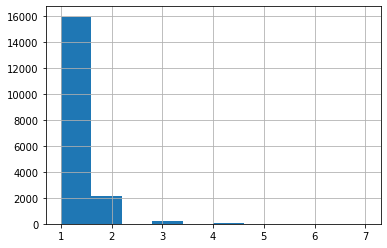

In [69]:
data['casebody.data.opinions'].str.len().hist()

In [14]:
data['casebody.data.opinions'].str.split().map(lambda x: len(x)).hist()

TypeError: object of type 'float' has no len()

In [15]:
data['casebody.data.opinions'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist()

TypeError: 'float' object is not iterable

In [16]:
json_normalize(data['casebody.data.opinions'][1])

,type,text,author
0,majority,"OPINION\nWECHSLER, Judge.\n1. As a result of a...","WECHSLER, Judge."


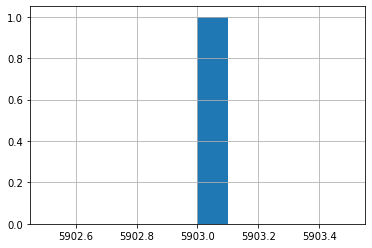

In [17]:
json_normalize(data['casebody.data.opinions'][1])['text'].str.split().map(lambda x: len(x)).hist()

## List of EDAs
1. ~~Volume of cases by day/month (time trendline)~~ I'm not sure if this is relevant for our project (Fernando)
1. Histogram of number cases authored by each judge
1. Length of judgments (pages and word count)
1. No. of cases with a minority opinion
1. Bar graph of number of cases by court
1. Missing values **(misspellings?--Fernando)**
1. Word cloud
1. Visualize embeddings of the text
1. Size of vocabulary
1. No. of distinct words used per judgment (histogram)
1. Most common words used (excluding stop-words)
1. tf-idf of words (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
1. Categorical meta-data
1. Entity-recognition? (https://github.com/openlegaldata/legal-ner) (https://spacy.io/usage/linguistic-features#named-entities)
1. Sentiment of judgment?


In [18]:
set([d['casebody']['status'] for d in data_json])

{'ok'}

In [19]:
data['casebody.data.opinions'].map(lambda x:len(x)).value_counts()

1    15919
2     2156
3      228
4       32
7        1
6        1
5        1
Name: casebody.data.opinions, dtype: int64

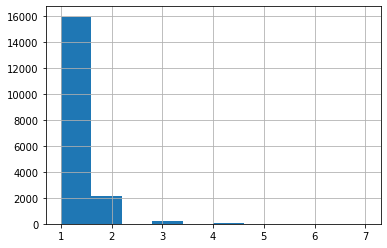

In [20]:
data['casebody.data.opinions'].map(lambda x:len(x)).hist()

In [62]:
data['casebody.data.opinions.text'] = data['casebody.data.opinions'].map(lambda x: x[0]['text'])
data['casebody.data.opinions.type0'] = data['casebody.data.opinions'].map(lambda x: x[0]['type'])

for i in range(1,7):
    data[f'casebody.data.opinions.type{i}'] = data['casebody.data.opinions'].map(lambda x: x[i]['type'] if len(x)>=i+1 else None)

In [63]:
data['casebody.data.opinions.text']

0        OPINION\nMINZNER, Justice.\n(1)Defendant Lonni...
1        OPINION\nWECHSLER, Judge.\n1. As a result of a...
2        OPINION\nPICKARD, Judge.\n¶ 1 This case requir...
3        OPINION\nBOSSON, Judge.\n1. Article II, Sectio...
4        OPINION\nPICKARD, Judge.\n1. Defendant appeals...
                               ...                        
18333    OPINION\nHARTZ, Chief Judge.\n(1) Defendant pl...
18334    OPINION\nKENNEDY, Judge.\nI. INTRODUCTION\n{1}...
18335    OPINION\nAPODACA, Chief Judge.\n1.Worker appea...
18336    OPINION\nBUSTAMANTE, Judge.\n{1} These consoli...
18337    McGHEE, Justice.\nThe appellants owned all of ...
Name: casebody.data.opinions.text, Length: 18338, dtype: object

In [64]:
data['casebody.data.opinions.text'][0]

'OPINION\nMINZNER, Justice.\n(1)Defendant Lonnie Woodruff appeals from a judgment and sentence entered after his conviction by a jury of driving while under the influence of. intoxicating liquor (DWI) contrary to NMSA 1978, § 66-8-102 (1994, prior to 1997 amendment). On appeal, he contends he was denied due process of law under the New Mexico Constitution when the district court enhanced his sentence from a first offense to a second offense as a result of a prior conviction for which he was not represented by counsel. We affirm.\nI.\n(2) Following Woodruffs conviction, the State filed a supplemental criminal information. In that supplemental information, the State alleged that Woodruff had two prior convictions for DWI. Defendant admitted that he was the person named in the two counts of the supplemental information. However, he challenged one of the convictions on the basis that the State failed to show he had waived his right to counsel and that he had not been represented by counsel

In [79]:
data['casebody.data.opinions.text'].str.len().value_counts()

245      33
83       32
244      22
166      21
167      19
         ..
14279     1
28548     1
16254     1
10109     1
6187      1
Name: casebody.data.opinions.text, Length: 13729, dtype: int64

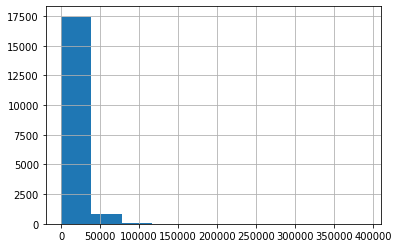

In [76]:
# the number of characters in each opinion
data['casebody.data.opinions.text'].str.len().hist()

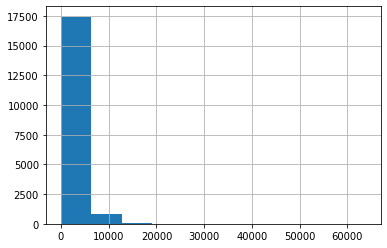

In [80]:
# the number of words appearing in each opinion
data['casebody.data.opinions.text'].str.split().map(lambda x: len(x)).hist()

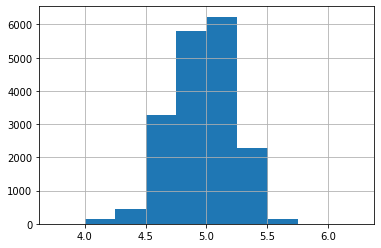

In [99]:
# the average word length in each opinion
data['casebody.data.opinions.text'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist()

In [24]:
data['casebody.data.opinions.type0'].value_counts()

majority       18324
rehearing         11
concurrence        3
Name: casebody.data.opinions.type0, dtype: int64

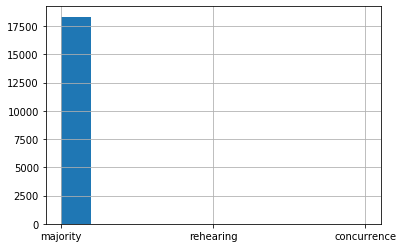

In [25]:
data['casebody.data.opinions.type0'].hist()

In [65]:
data['casebody.data.opinions.type6'].value_counts()

dissent    1
Name: casebody.data.opinions.type6, dtype: int64

In [100]:
opinions = data['casebody.data.opinions.text'].str.split().values.tolist()
words = []
for word in opinions:
    words += word

In [111]:
# the number of times a word appears in all opinions
pd.DataFrame(words).stack().value_counts()

the                       3303246
of                        1722385
to                        1297921
and                        964640
that                       818157
                           ...   
Messeroff,                      1
deformed."                      1
(Bkrtcy.E.D.N.Y.1990);          1
address),                       1
FraNCIsco                       1
Length: 632132, dtype: int64